In [2]:
import numpy as np
import pysam
from Bio import SeqIO
from matplotlib import pyplot as plt
%matplotlib inline

# Processing datasets

``minimap2 -d reference.mmi reference.fasta``

``minimap2 -ax map-pb reference.mmi pacbio_40x.fq > pb_aln.sam``

``minimap2 -ax map-ont reference.mmi ONT_2D.fastq > ont_aln.sam``

``samtools flagstat pb_aln.sam``;   __mapped__: 48434 (97.37%)

``samtools flagstat ont_aln.sam``;   __mapped__: 29565 (92.09%)

# Methods

In [1]:
def coverage_stats(filename, dataset, blocksize=1000):
    coverage = []
    genome_len, covered = 0, 0
    with open(filename) as f:
        for line in f:
            line = line.split('\t')
            coverage.append(int(line[2]))
            genome_len += 1
            if int(line[2]) != 0:
                covered += 1
    
    print("Dataset: {}\n"
          "Average coverage: {:.3f}\n"
          "Covered genome percent: {:.3f}%\n"
          .format(dataset, sum(coverage) / genome_len, covered / genome_len * 100))
    
    # count avg coverage per block of blocksize nucleotides
    blocks_avg = [sum(coverage[i:min(genome_len, i + blocksize)]) / min(blocksize, genome_len - i) 
                  for i in range(0, genome_len, blocksize)]
    
    xticks = ["{}-{}".format(i, min(genome_len, i + blocksize))
              for i in range(0, genome_len, blocksize)]
    xrange = [i for i in range(len(xticks))]
    # in case of too much xticks
    if len(xticks) > 50:
        xticks = [xticks[i] for i in range(0, len(xticks), 50)]
        xrange = [xrange[i] for i in range(0, len(xrange), 50)]
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(blocks_avg)), blocks_avg)
    plt.xticks(xrange, xticks, rotation=30, fontsize=8)
    plt.xlabel("nucleotides positions")
    plt.ylabel("average coverage")
    plt.title("Genome coverage")
    plt.show()

In [2]:
def count_error_percentage(filename, dataset):
    errors = []
    with open(filename) as f:
        for line in f:
            line = line.split(' ')
            if line[2].startswith('NM') and line[0] != '*':
                e = int(line[2].replace('\n', '').split(':')[2])
                errors.append(e / int(line[1]))
    
    avg = sum(errors) / len(errors)
    
    print("Dataset: {}\n"
          "Mean errors percentage per read: {:.3f}%\n"
          .format(dataset, avg * 100))

In [25]:
def count_subst_freqs(filename, dataset):
    freqs_matrix = {}
    for ref in ('ACTG-'):
        for alt in ('ACTG-'):
            if alt != ref:
                freqs_matrix[(alt, ref)] = 0
                
    bamfile = pysam.AlignmentFile(filename, 'rb')
    for read in bamfile.fetch():
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue
            
        # remove skippings
        s1 = -1
        s2 = len(aln_pairs)
        while aln_pairs[s1 + 1][1] is None:
            s1 += 1
        while aln_pairs[s2 - 1][1] is None:
            s2 -= 1
        aln_pairs = aln_pairs[s1 + 1 : s2]
        
        read_seq = read.seq
        for p in aln_pairs:
            if p[0] is None:
                freqs_matrix[('-', p[2])] += 1
            elif p[1] is None and read_seq[p[0]] != 'N':
                freqs_matrix[(read_seq[p[0]], '-')] += 1
            elif p[1] is not None and p[2].lower() == p[2] and read_seq[p[0]] != 'N':
                freqs_matrix[(read_seq[p[0]], p[2].upper())] += 1
                
    print('Dataset: {}\n'.format(dataset))
    print('   A\t\tC\t\tT\t\tG\t\t-')
    for alt in 'ACTG-':
        print(alt, end='  ')
        for ref in 'ACTG-':
            if alt == ref:
                print('*\t\t', end='')
            else:
                print(freqs_matrix[(alt, ref)], 
                      end='\t' + ('\t' if len(str(freqs_matrix[(alt, ref)])) < 5 or ref != 'A' else ''))
        print()

In [3]:
def indel_stats(filename, dataset):
    length = []
    ins = []
    dels = []
    
    with open(filename) as f:
        for line in f:
            line = line.replace('\n', '').split('\t')
            length.append(int(line[0]))
            ins.append(int(line[1]))
            dels.append(int(line[2]))
    
    mean_ins = sum([i * l for (i, l) in zip(ins, length)]) / sum(ins)
    mean_dels = sum([d * l for (d, l) in zip(dels, length)]) / sum(dels)
    
    print('Dataset: {}\n'
          'Mean insertion length: {:.3f}\n'
          'Mean deletion length: {:.3f}\n'
          .format(dataset, mean_ins, mean_dels))
    
    plt.figure(figsize=(7, 12))
    plt.subplot(211)
    plt.plot(length, ins)
    plt.xlabel('insertion length')
    plt.ylabel('n insertions')
    plt.title('Insertion length distribution')
    
    plt.subplot(212)
    plt.plot(length, dels)
    plt.xlabel('deletion length')
    plt.ylabel('n deletions')
    plt.title('Deletion length distribution')

# Coverage

``samtools sort pb_aln.sam > pb_aln.bam``

``samtools depth pb_aln.bam > pb_aln_coverage``

Dataset: PacBio reads
Average coverage: 38.143
Covered genome percent: 100.000%



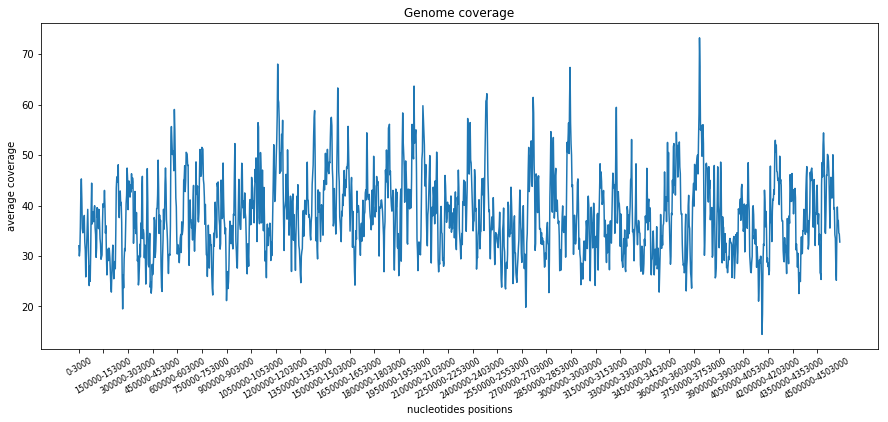

In [5]:
coverage_stats('pb_aln_coverage', 'PacBio reads', blocksize=3000)

``samtools sort ont_aln.sam > ont_aln.bam``

``samtools depth ont_aln.bam > ont_aln_coverage``

Dataset: Oxford Nanopore reads
Average coverage: 26.651
Covered genome percent: 99.982%



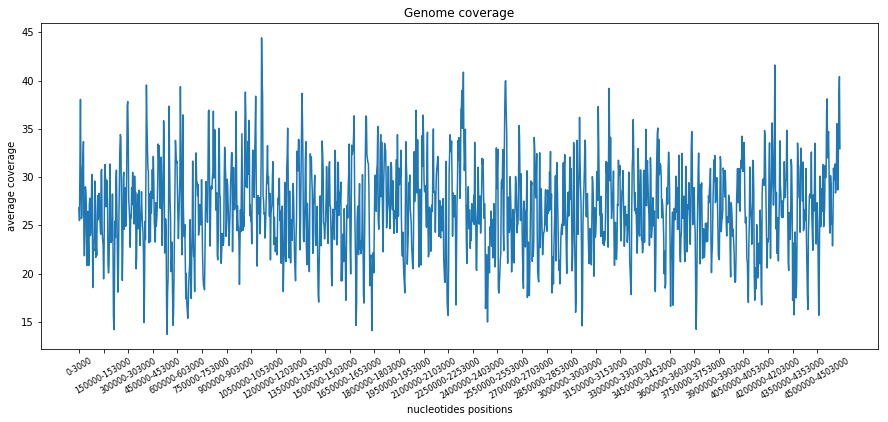

In [6]:
coverage_stats('ont_aln_coverage', 'Oxford Nanopore reads', blocksize=3000)

# Errors percentage

``cat pb_aln.sam | awk 'NR>2 {print $10,length($10),$12}' > pb_errors``

``cat ont_aln.sam | awk 'NR>2 { print $10,length($10),$12}' > ont_errors``

In [27]:
count_error_percentage('pb_errors', 'PacBio reads')

Dataset: PacBio reads
Mean errors percentage per read: 12.693%



In [28]:
count_error_percentage('ont_errors', 'Oxford Nanopore reads')

Dataset: Oxford Nanopore reads
Mean errors percentage per read: 8.028%



# Substitution distribution

``samtools calmd -b pb_aln.bam reference.fasta > pb_aln_with_MD.bam`` 

``samtools index pb_aln_with_MD.bam``

``samtools calmd -b ont_aln.bam reference.fasta > ont_aln_with_MD.bam`` 

``samtools index ont_aln_with_MD.bam``

In [26]:
count_subst_freqs('pb_aln_with_MD.bam', 'PacBio reads')

Dataset: PacBio reads

   A		C		T		G		-
A  *		457338		285699		322254		3595384		
C  354487	*		309393		415583		4480844		
T  285427	321990		*		450152		3577631		
G  307539	414331		359744		*		4483786		
-  1439867	2074963		1436033		2067558		*		


In [23]:
count_subst_freqs('ont_aln_with_MD.bam', 'Oxford Nanopore reads')

Dataset: Oxford Nanopore reads

   A		C		T		G		-
A  *		137046		107765		319761		398409		
C  112963	*		372780		91353		378519		
T  105373	340675		*		126487		394386		
G  368487	85027		111447		*		394700		
-  1608029	1537154		1604787		1559017		*		


# Indels distribution

``samtools stats ont_aln.bam > ont_aln_stats``

``cat ont_aln_stats | grep ^ID | cut -f 2- > ont_indel_distr``

``samtools stats pb_aln.bam > pb_aln_stats``

``cat pb_aln_stats | grep ^ID | cut -f 2- > pb_indel_distr``

Dataset: PacBio reads
Mean insertion length: 1.508
Mean deletion length: 1.199



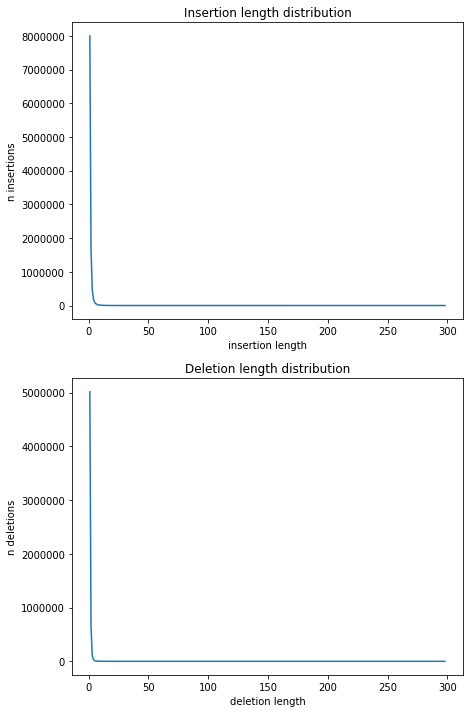

In [4]:
indel_stats('pb_indel_distr', 'PacBio reads')

Dataset: Oxford Nanopore reads
Mean insertion length: 1.727
Mean deletion length: 1.884



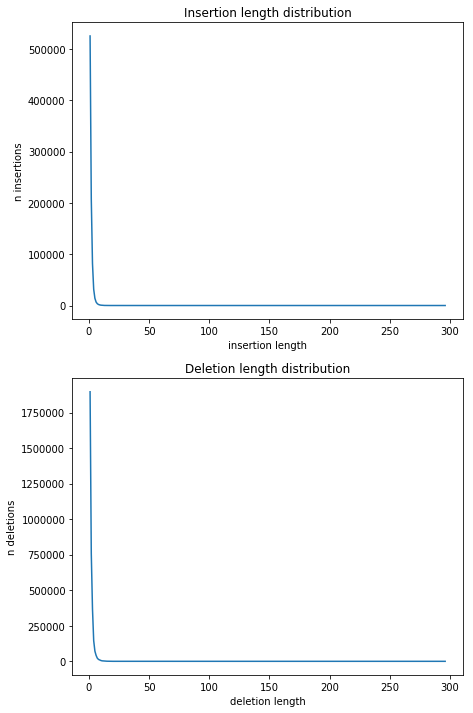

In [6]:
indel_stats('ont_indel_distr', 'Oxford Nanopore reads')